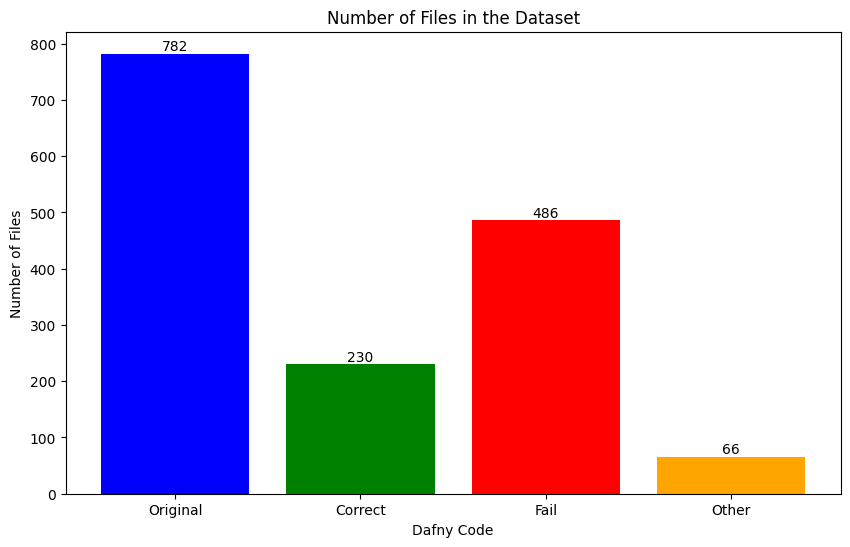

In [1]:
import os
import matplotlib.pyplot as plt

# Directory paths
original_dir = r'Original_Code'
correct_dir = r'Correct_Code'
fail_dir = r'Fail_Code\Code'
other_dir = r'Other_Code'

# Function to count files in a directory
def count_files(directory):
    try:
        return len(os.listdir(directory))
    except FileNotFoundError:
        return 0

# Count files in each directory
original_count = count_files(original_dir)
correct_count = count_files(correct_dir)
fail_count = count_files(fail_dir)
other_count = count_files(other_dir)

# Calculate total files in original directory
total_original = original_count
total_correct = correct_count
total_fail = fail_count
total_other = other_count

# Plotting the bar chart with value annotations
labels = ['Original', 'Correct', 'Fail', 'Other']
counts = [total_original, total_correct, total_fail, total_other]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Dafny Code')
plt.ylabel('Number of Files')
plt.title('Number of Files in the Dataset')

# Adding the value annotations on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()


C:\Users\filip\AppData\Local\Temp\ipykernel_14020\2780565126.py:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


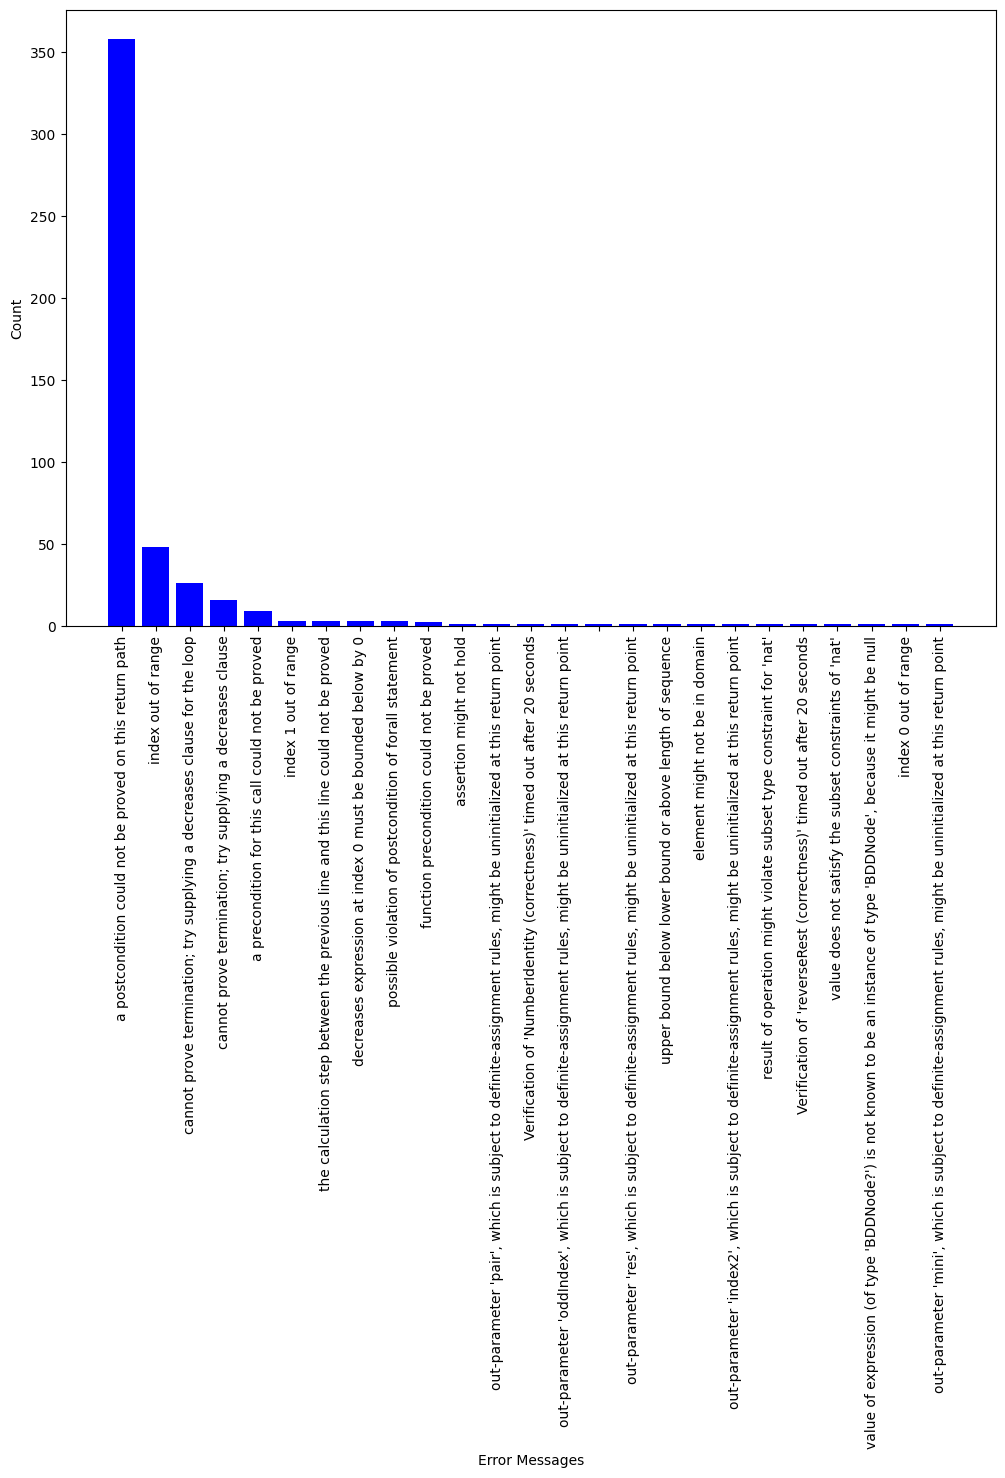

In [2]:
import os
import matplotlib.pyplot as plt

# Directory path for error messages
error_dir = r'Fail_Code\MessageError'

# Function to count error messages
def count_error_messages(error_dir):
    error_messages = {}

    # Iterate through each file in the directory
    for file_name in os.listdir(error_dir):
        file_path = os.path.join(error_dir, file_name)
        if os.path.isfile(file_path):
            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    message_error = file.read().strip()
                    if message_error in error_messages:
                        error_messages[message_error] += 1
                    else:
                        error_messages[message_error] = 1
            except Exception as e:
                print(f"Error reading file {file_path}: {e}")

    return error_messages

# Count error messages
error_messages = count_error_messages(error_dir)

# Sort error messages by count (descending)
sorted_error_messages = dict(sorted(error_messages.items(), key=lambda item: item[1], reverse=True))

# Prepare data for plotting
labels = list(sorted_error_messages.keys())
counts = list(sorted_error_messages.values())

# Plotting the bar chart
plt.figure(figsize=(12, 8))
plt.bar(labels, counts, color='blue')
plt.xlabel('Error Messages')
plt.ylabel('Count')
# plt.title('Frequency of Error Messages in Fail_Code\MessageError Directory')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [2]:
import os
import pandas as pd

def read_file_content(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except FileNotFoundError:
        return None

def find_buggy_line(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for i, line in enumerate(file, 1):
                if "//buggy line" in line:
                    return i
    except FileNotFoundError:
        return None
        
def create_table(code_dir, fault_loc_dir, code_block_dir, hint_dir):
    # Get base names of files in code_dir
    code_files = {os.path.splitext(file)[0] for file in os.listdir(code_dir) if os.path.isfile(os.path.join(code_dir, file))}
    
    data = []
    
    for base_name in code_files:
        fault_loc_path = os.path.join(fault_loc_dir, base_name + '.txt')
        code_block_path = os.path.join(code_block_dir, base_name + '.txt')
        
        fault_loc_content = read_file_content(fault_loc_path)
        code_block_content = read_file_content(code_block_path)
        
        type_found = None
        buggy_line = None

        # Walk through hint_dir to find the type and buggy line
        for root, dirs, files in os.walk(hint_dir):
            if base_name + '.dfy' in files:
                type_found = os.path.basename(root)
                buggy_line = find_buggy_line(os.path.join(root, base_name + '.dfy'))
                break
        
        data.append({
            'Name': base_name,
            'Fault_Loc': fault_loc_content,
            'Total_Lines': code_block_content,
            'Type': type_found,
            'Line': buggy_line
        })
    
    df = pd.DataFrame(data)
    return df

In [3]:
import os
import pandas as pd

def read_file_content(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except FileNotFoundError:
        return None

def find_buggy_line(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for i, line in enumerate(file, 1):
                if "//buggy line" in line:
                    return i
    except FileNotFoundError:
        return None

def get_type_and_buggy_line(base_name, hint_dir):
    for root, dirs, files in os.walk(hint_dir):
        if base_name + '.dfy' in files:
            type_found = os.path.basename(root)
            buggy_line = find_buggy_line(os.path.join(root, base_name + '.dfy'))
            return type_found, buggy_line
    return None, None

def add_type_and_line_columns(df, hint_dir):
    types = []
    lines = []
    
    for base_name in df['Name']:
        type_found, buggy_line = get_type_and_buggy_line(base_name, hint_dir)
        types.append(type_found)
        lines.append(buggy_line)
    
    df['Type'] = types
    df['Line'] = lines
    
    return df

In [4]:
# Directories
code_dir = r'All_Bugs_Code\Code'
fault_loc_dir = r'All_Bugs_Code\FaultLocalization'
code_block_dir = r'All_Bugs_Code\Code_Block_Method'
hint_dir = r'Bugs_Code\Hints'

# Create the table
table_df = create_table(code_dir, fault_loc_dir, code_block_dir, hint_dir)

In [5]:
df_with_type_and_line = add_type_and_line_columns(table_df, hint_dir)

In [6]:
def verify_buggy_line_in_fault_loc(buggy_line, fault_loc):
    if pd.isna(fault_loc):
        return False
    fault_lines = [int(x.strip()) for x in fault_loc.split(';') if x.strip().isdigit()]
    return buggy_line in fault_lines

def add_verify_column(df):
    verifies = []
    
    for index, row in df.iterrows():
        buggy_line = row['Line']
        fault_loc = row['Fault_Loc']
        verifies.append(verify_buggy_line_in_fault_loc(buggy_line, fault_loc))
    
    df['Verify'] = verifies
    
    return df

In [7]:
table = add_verify_column(table_df)

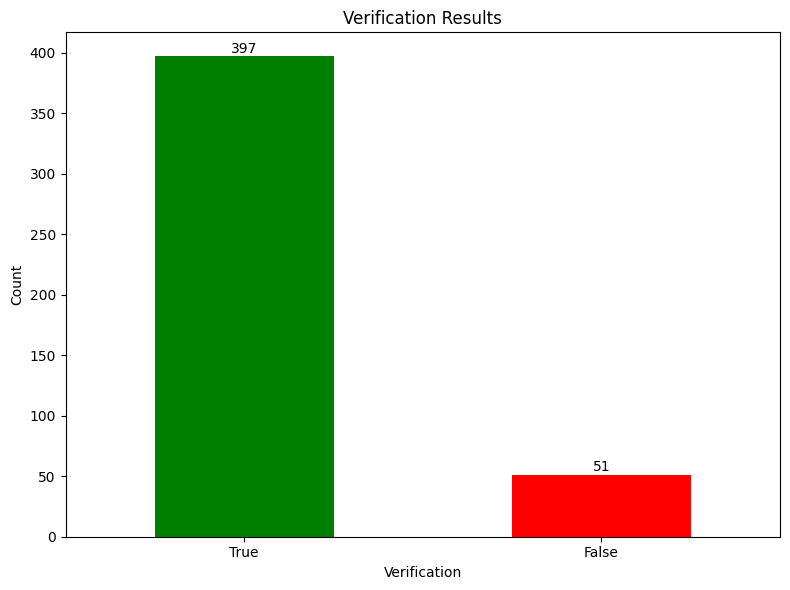

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Count occurrences of 'yes' and 'no' in the Verify column
verify_counts = table['Verify'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
verify_counts.plot(kind='bar', color=['green', 'red'])

plt.title('Verification Results')
plt.xlabel('Verification')
plt.ylabel('Count')

# Display counts on top of the bars
for i, count in enumerate(verify_counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

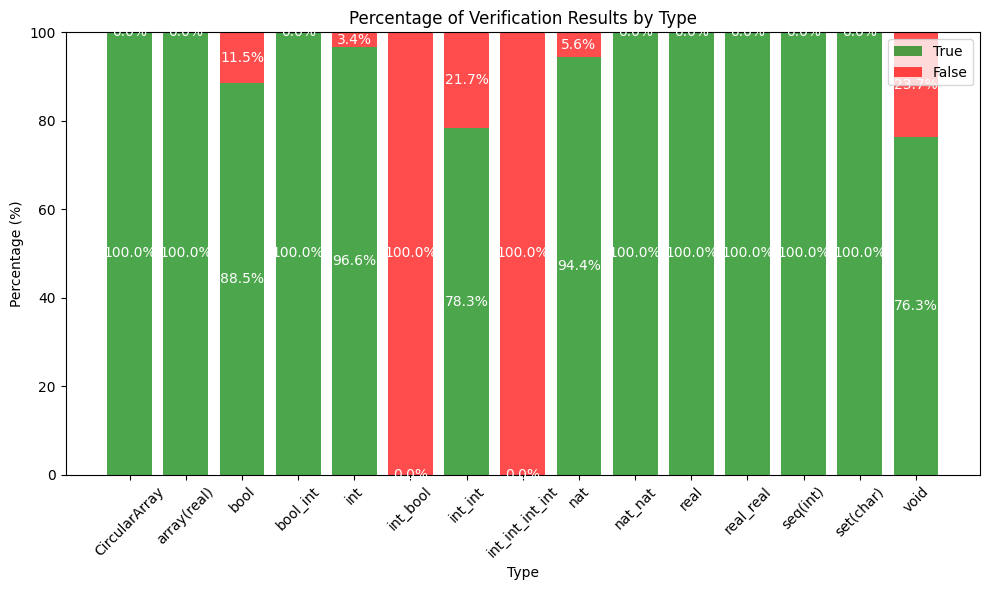

In [9]:
# Group by Type and calculate counts of 'true' and 'false'
verify_counts = table.groupby('Type')['Verify'].value_counts(normalize=True).unstack(fill_value=0) * 100

# Plotting
plt.figure(figsize=(10, 6))

# Plotting 'true' percentages
plt.bar(verify_counts.index, verify_counts[True], label='True', color='green', alpha=0.7)

# Plotting 'false' percentages
plt.bar(verify_counts.index, verify_counts[False], bottom=verify_counts[True], label='False', color='red', alpha=0.7)

plt.title('Percentage of Verification Results by Type')
plt.xlabel('Type')
plt.ylabel('Percentage (%)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Adding percentage labels
for i, (true_val, false_val) in enumerate(zip(verify_counts[True], verify_counts[False])):
    plt.text(i, true_val / 2, f'{true_val:.1f}%', ha='center', va='center', color='white')
    plt.text(i, true_val + false_val / 2, f'{false_val:.1f}%', ha='center', va='center', color='white')

plt.show()

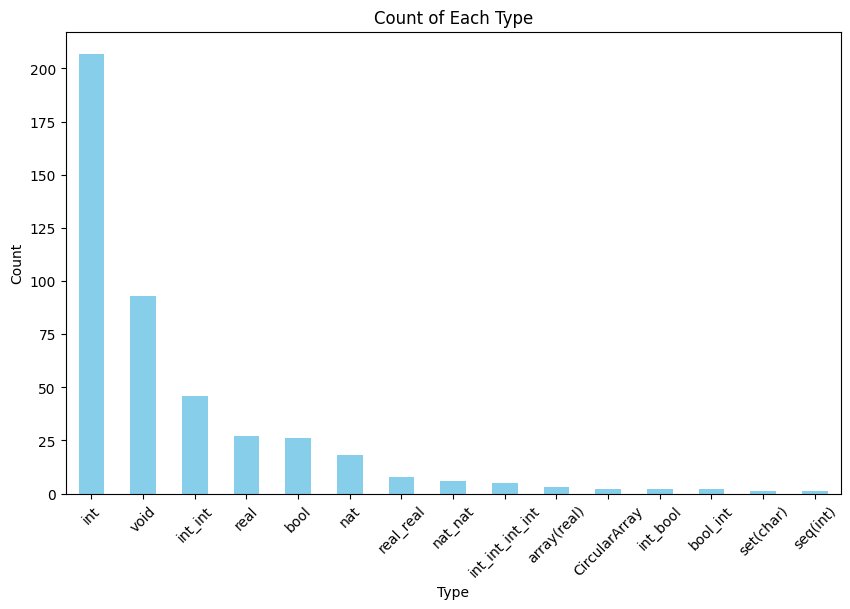

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the occurrences of each type
type_counts = table['Type'].value_counts()

# Plot the counts
plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Each Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.show()

C:\Users\filip\AppData\Local\Temp\ipykernel_13904\2652282335.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


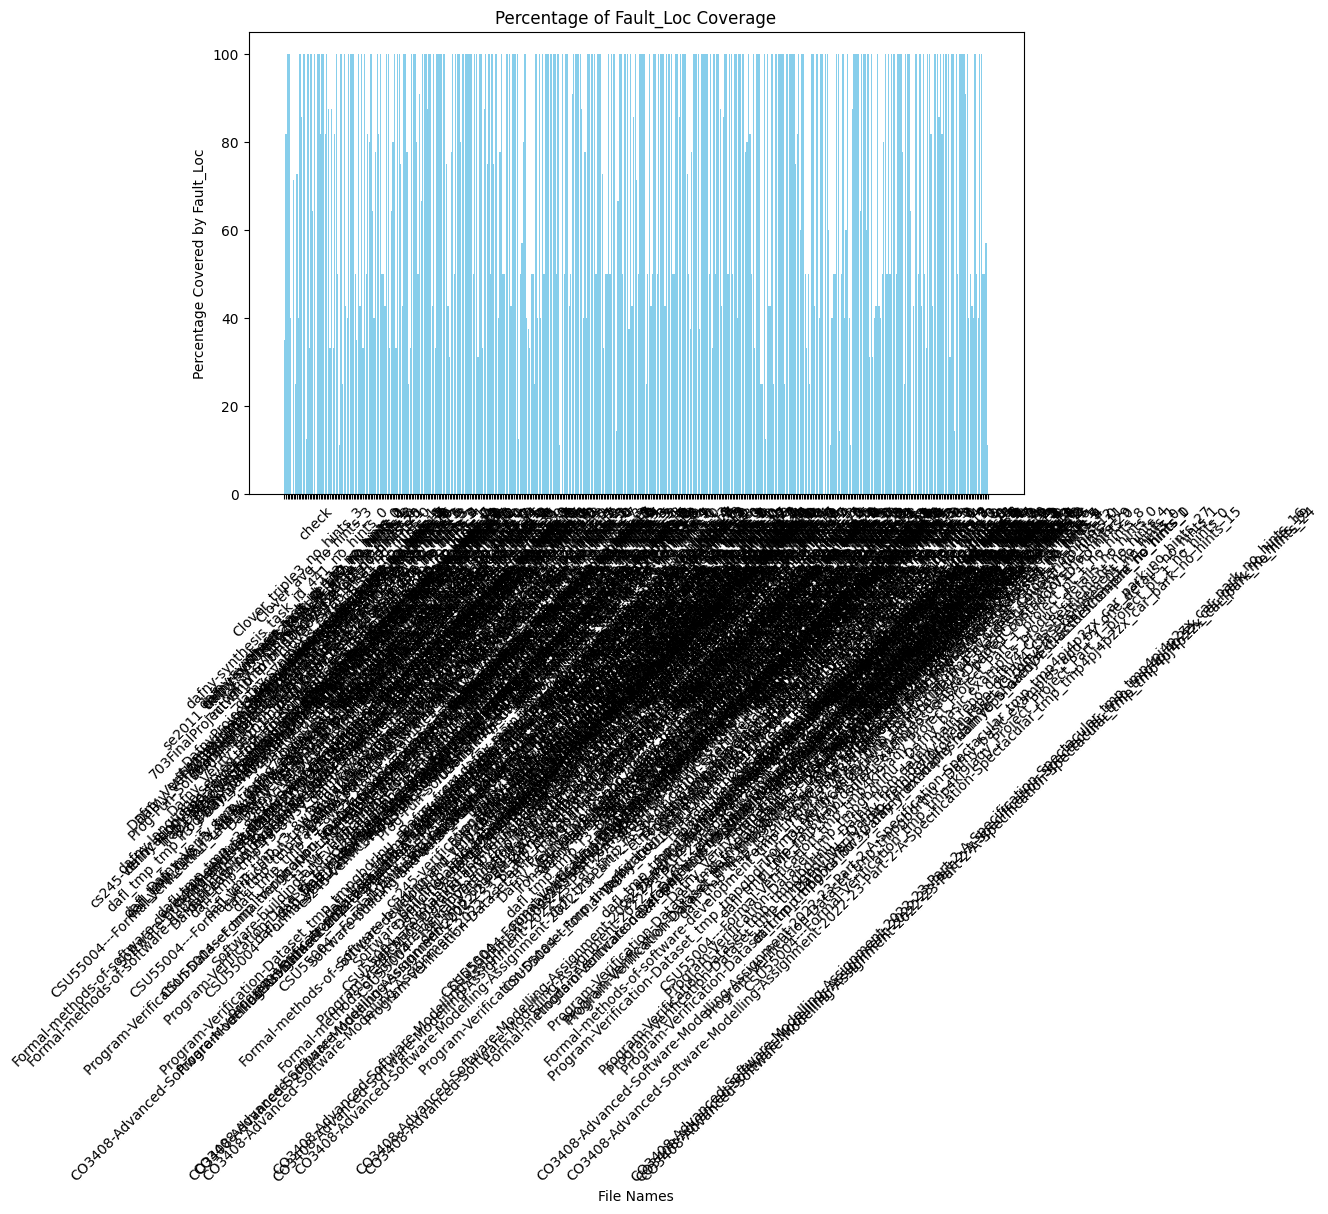

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = table.copy()

# Function to safely convert string representation to list of integers
def convert_to_list(s):
    if pd.notna(s):
        try:
            # Remove '[' and ']' characters, split by ',' and convert to integer
            stripped = s.strip('[]')
            elements = stripped.split(',')
            return [int(elem.strip()) for elem in elements if elem.strip().isdigit()]
        except ValueError:
            return []
    else:
        return []

# Apply the conversion function to 'Total_Lines' column
df['Total_Lines'] = df['Total_Lines'].apply(convert_to_list)

# Function to clean and split Fault_Loc considering possible newline characters
def clean_and_split(s):
    if pd.notna(s):
        cleaned = s.strip().rstrip('\n')  # Remove leading/trailing whitespace and '\n'
        return cleaned.split(';')
    else:
        return []

df['Fault_Loc'] = df['Fault_Loc'].apply(clean_and_split)

# Calculate the percentage of Fault_Loc compared to Total_Lines
def calculate_percentage(fault_loc, total_lines):
    try:
        fault_lines = [int(line) for line in fault_loc if line.strip().isdigit()]
        total_lines = [int(line) for line in total_lines]
        return (len(fault_lines) / len(total_lines)) * 100 if len(total_lines) > 0 else 0
    except ValueError:
        return 0

df['Fault_Loc_Percentage'] = df.apply(lambda row: calculate_percentage(row['Fault_Loc'], row['Total_Lines']), axis=1)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(df['Name'], df['Fault_Loc_Percentage'], color='skyblue')
plt.xlabel('File Names')
plt.ylabel('Percentage Covered by Fault_Loc')
plt.title('Percentage of Fault_Loc Coverage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\filip\AppData\Local\Temp\ipykernel_13904\101430882.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yes['Percentage_Bin'] = pd.cut(df_yes['Fault_Loc_Percentage'], bins=bins, right=False)


Percentage Range	Count
[0, 10)		0
[10, 20)		6
[20, 30)		4
[30, 40)		12
[40, 50)		38
[50, 60)		36
[60, 70)		11
[70, 80)		18
[80, 90)		29
[90, 100)		3


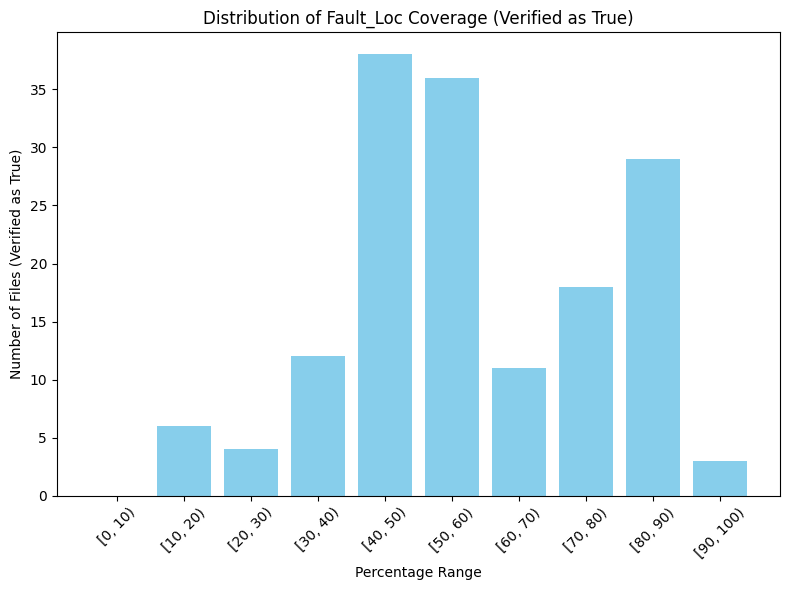

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df already contains the necessary data and a 'Verify' column

# Filter the DataFrame to include only rows where 'Verify' is 'Yes'
df_yes = df[df['Verify'] == True]

# Create bins for percentages (10% intervals)
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Use pd.cut to categorize Fault_Loc_Percentage into bins
df_yes['Percentage_Bin'] = pd.cut(df_yes['Fault_Loc_Percentage'], bins=bins, right=False)

# Count how many files fall into each percentage range
percentage_counts_yes = df_yes['Percentage_Bin'].value_counts().sort_index()

# Display the counts
print("Percentage Range\tCount")
for range_name, count in percentage_counts_yes.items():
    print(f"{range_name}\t\t{count}")

# Plotting the distribution for "Yes" lines
plt.figure(figsize=(8, 6))
plt.bar(percentage_counts_yes.index.astype(str), percentage_counts_yes.values, color='skyblue')
plt.xlabel('Percentage Range')
plt.ylabel('Number of Files (Verified as True)')
plt.title('Distribution of Fault_Loc Coverage (Verified as True)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


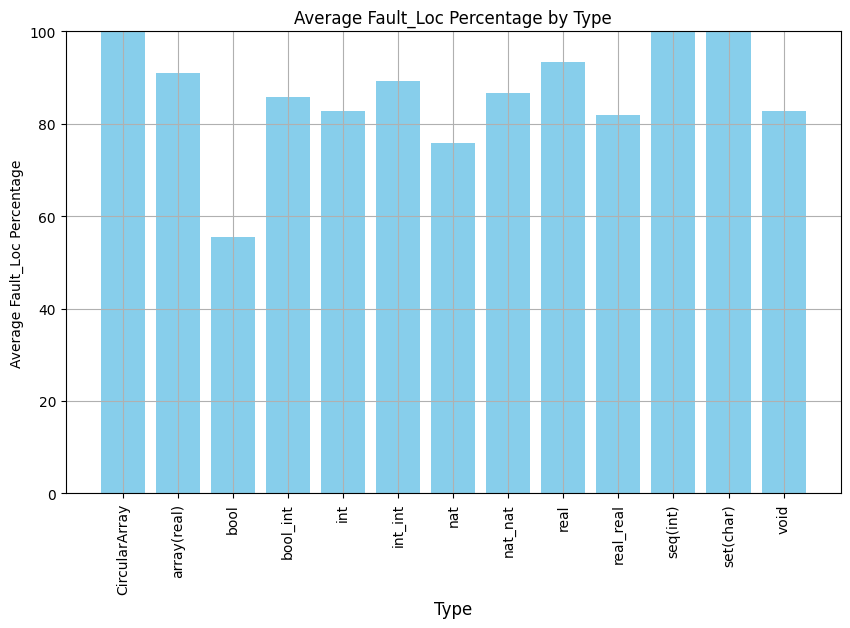

In [13]:
# Group by 'Type' and aggregate mean Fault_Loc_Percentage
df_true = df[df['Verify'] == True]
grouped = df_true.groupby('Type')['Fault_Loc_Percentage'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(grouped['Type'], grouped['Fault_Loc_Percentage'], color='skyblue')
plt.xlabel('Type', fontsize=12)
plt.ylabel('Average Fault_Loc Percentage')
plt.title('Average Fault_Loc Percentage by Type')
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100%
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

C:\Users\filip\AppData\Local\Temp\ipykernel_13904\2143213375.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yes['Percentage_Bin'] = pd.cut(df_yes['Fault_Loc_Percentage'], bins=bins, right=True, include_lowest=True)


Faixa de Porcentagem	Contagem
(-0.001, 10.0]		0
(10.0, 20.0]		6
(20.0, 30.0]		4
(30.0, 40.0]		29
(40.0, 50.0]		55
(50.0, 60.0]		6
(60.0, 70.0]		7
(70.0, 80.0]		25
(80.0, 90.0]		22
(90.0, 100.0]		243


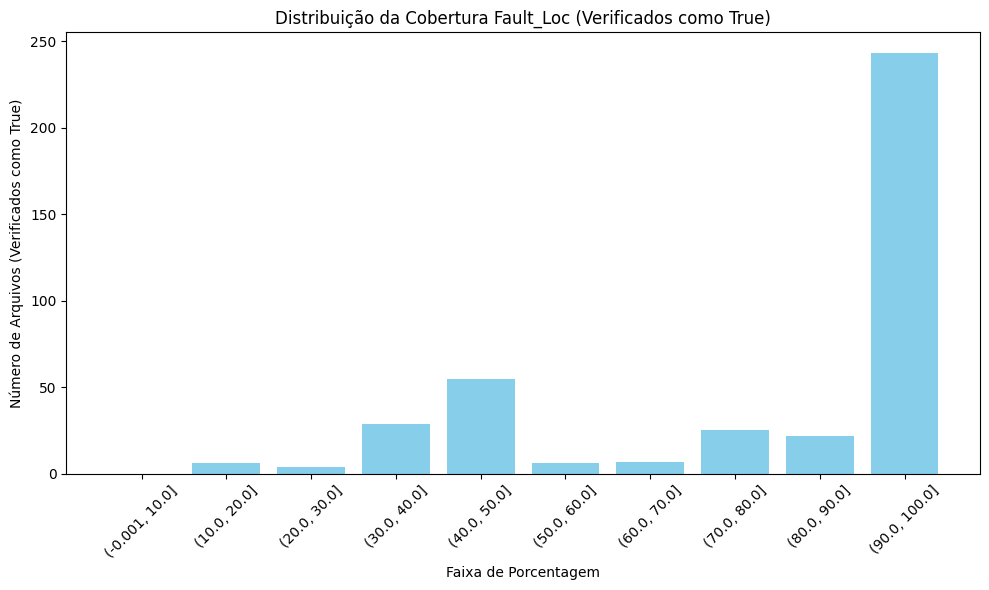

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que df já contém os dados necessários e a coluna 'Verify'

# Filtrar o DataFrame para incluir apenas linhas onde 'Verify' é 'True'
df_yes = df[df['Verify'] == True]

# Criar intervalos para porcentagens (intervalos de 10%)
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Usar pd.cut para categorizar 'Fault_Loc_Percentage' em intervalos, incluindo 100%
df_yes['Percentage_Bin'] = pd.cut(df_yes['Fault_Loc_Percentage'], bins=bins, right=True, include_lowest=True)

# Contar quantos arquivos caem em cada intervalo de porcentagem
percentage_counts_yes = df_yes['Percentage_Bin'].value_counts().sort_index()

# Exibir as contagens
print("Faixa de Porcentagem\tContagem")
for range_name, count in percentage_counts_yes.items():
    print(f"{range_name}\t\t{count}")

# Plotar a distribuição para linhas verificadas como "Yes"
plt.figure(figsize=(10, 6))
plt.bar(percentage_counts_yes.index.astype(str), percentage_counts_yes.values, color='skyblue')
plt.xlabel('Faixa de Porcentagem')
plt.ylabel('Número de Arquivos (Verificados como True)')
plt.title('Distribuição da Cobertura Fault_Loc (Verificados como True)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
import pandas as pd
import ast

# if give some error uncomment the code
# Convert 'Total_Lines' from string representation of lists to actual lists 
#df['Total_Lines'] = df['Total_Lines'].apply(lambda x: ast.literal_eval(x))

# Calculate the length of each list in 'Total_Lines'
df['Total_Lines_Num'] = df['Total_Lines'].apply(len)

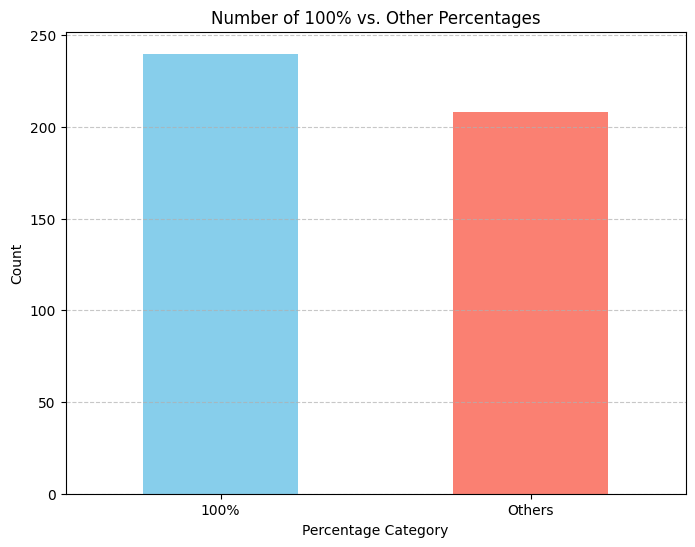

In [22]:
# Create a new column to categorize percentages into '100%' and 'Others'
df['Category'] = df['Fault_Loc_Percentage'].apply(lambda x: '100%' if x == 100 else 'Others')

# Count occurrences of each category
counts = df['Category'].value_counts()

# Plot the data
plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Number of 100% vs. Other Percentages')
plt.xlabel('Percentage Category')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels to horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [28]:
df.columns

Index(['Name', 'Fault_Loc', 'Total_Lines', 'Type', 'Line', 'Verify',
       'Fault_Loc_Percentage', 'Category', 'Total_Lines_Num'],
      dtype='object')

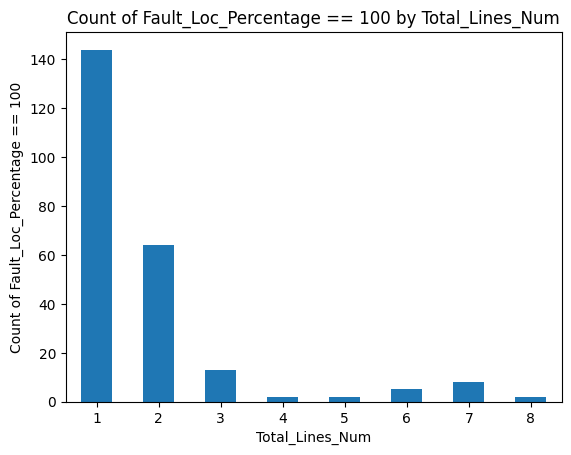

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Filter rows where Fault_Loc_Percentage is 100
filtered_df = df[df['Fault_Loc_Percentage'] == 100]

# Group by 'Total_Lines_Num' and count the occurrences
grouped = filtered_df.groupby('Total_Lines_Num').size()

# Plotting
grouped.plot(kind='bar')
plt.xlabel('Total_Lines_Num')
plt.ylabel('Count of Fault_Loc_Percentage == 100')
plt.title('Count of Fault_Loc_Percentage == 100 by Total_Lines_Num')
plt.xticks(rotation=0)
plt.show()

In [29]:
# Optionally, save the table to a CSV file
output_csv = r'Tables\fault_loc_table.csv'
df.to_csv(output_csv, index=False)